# Combining measurements

When we do a fit, we can have additional knowledge about a parameter from other measurements. This can be taken into account either through a simultaneous fit or by adding a constraint (subsidiary measurement).

## Adding a constraint

If we know a parameters value from a different measurement and want to constraint this using its uncertainty, a Gaussian constraint can be added to the likelihood as

\begin{align}
\mathrm{constr_i} = \mathrm{Gauss}(\mu_{measured}; \theta_i, \sigma_{measured})
\end{align}

In general, additional terms can be added to the likelihood arbitrarily in zfit, be it to incorporate other shaped measurements or to add penalty terms to confine a fit within boundaries.

In [1]:
import zfit
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep
import hepunits as u
import particle.literals as lp

plt.rcParams['figure.figsize'] = (8,6)

In [2]:
mu_true =  lp.B_plus.mass * u.MeV
sigma_true = 50 * u.MeV

# number of signal and background
n_sig_rare = 120
n_bkg_rare = 700

In [3]:
# create some data
signal_np = np.random.normal(loc=mu_true, scale=sigma_true, size=n_sig_rare)
bkg_np_raw = np.random.exponential(size=20000, scale=700)
bkg_np = bkg_np_raw[bkg_np_raw<1000][:n_bkg_rare] + 5000  # just cutting right, but zfit could also cut

In [4]:
# Firstly, the observable and its range is defined
obs = zfit.Space('Bmass', (5000, 6000))  # for whole range

In [5]:
# load data into zfit
data = zfit.Data.from_numpy(obs=obs, array=np.concatenate([signal_np, bkg_np], axis=0))

In [6]:


# Parameters are specified:  (name (unique), initial, lower, upper) whereas lower, upper are optional
mu = zfit.Parameter('mu', 2790, 5100, 5400)
sigma = zfit.Parameter('sigma', 20, 1, 200)
signal = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)

lam = zfit.Parameter('lambda', -0.002, -0.1, -0.00001, step_size=0.001)  # floating, also without limits
comb_bkg = zfit.pdf.Exponential(lam, obs=obs)

sig_yield = zfit.Parameter('sig_yield', n_sig_rare + 30,
                                step_size=3)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', n_bkg_rare - 40, step_size=1)
# Create extended PDFs
extended_sig = signal.create_extended(sig_yield)
extended_bkg = comb_bkg.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

In [7]:
constraint = zfit.constraint.GaussianConstraint(mu, observation=5275 * u.MeV, uncertainty=15 * u.MeV)

In [8]:
nll = zfit.loss.ExtendedUnbinnedNLL(model, data, constraints=constraint)
minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
result = minimizer.minimize(nll)
result.hesse();

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
------------------------------------------------------------------
| FCN = 865.7                   |     Ncalls=183 (183 total)     |
| EDM = 5.28e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
--

In [9]:
print(result.params)

name           value    minuit_hesse    at limit
---------  ---------  --------------  ----------
bkg_yield      724.9     +/-      33       False
sig_yield      95.13     +/-      22       False
lambda     -0.001627     +/- 0.00014       False
mu              5286     +/-     8.9       False
sigma          38.01     +/-      11       False


## Simultaneous fits

Sometimes, we don't want to fit a single channel but multiple with the same likelihood and having shared parameters between them. In this example, we will fit the decay simultaneously to its resonant control channel.

A simultaneous likelihood is the product of different likelihoods defined by
\begin{align}
\mathcal{L}_{f(x)}(\theta | {data_0, data_1, ..., data_n}) &= \prod_{i=1}^{n} \mathcal{L}(\theta_i, data_i)
\end{align}

and becomes in the NLL a sum

\begin{align}
\mathrm{NLL}_{f(x)}(\theta | {data_0, data_1, ..., data_n}) &= \sum_{i=1}^{n} \mathrm{NLL}(\theta_i, data_i)
\end{align}



In [10]:
n_sig_reso = 40000
n_bkg_reso = 3000

In [11]:
# create some data
signal_np_reso = np.random.normal(loc=mu_true, scale=sigma_true * 0.7, size=n_sig_reso)
bkg_np_raw_reso = np.random.exponential(size=20000, scale=900)
bkg_np_reso = bkg_np_raw_reso[bkg_np_raw_reso<1000][:n_bkg_reso] + 5000

# load data into zfit
obs_reso = zfit.Space('Bmass_reso', (5000, 6000))
data_reso = zfit.Data.from_numpy(obs=obs_reso, array=np.concatenate([signal_np_reso, bkg_np_reso], axis=0))

### Sharing and composing parameters

As an example, the same signal shape will be used with the identical `mu` yet a scaled `sigma`. This means that the `sigma` of our control mode corresponds to the `sigma` of our signal times a scaling parameter. Therefore, the `scaled_sigma` is a function of two other parameters, `sigma` and `sigma_scaling` and _cannot_ change it's value independently. There are two fundamentally distinct types to represent this behavior in zfit, independent (`Parameter`) and dependent parameters (`ComplexParameter`, `ComposedParameter`,...)

#### Independent parameter

An independent parameter has, as a distinctive method, a `set_value` that _changes_ the value of the parameter. In a fit, or in general, these are _the only object_ that can directly change their value and therefore do not depend on other objects while most other objects depend on Parameters.
As a consequence, this parameters can have limits (which effectively restrict the possible values a `Parameter` can be assigned to) and have a `step_size`, a hint to any minimization algorithm about the order of magnitude that a change in the parameter will have on the loss.

Another attribute is a `floating` flag: if set to `False`, the parameter won't be floating in the fit, whether explicitly given or implicitly inferred from the dependencies.

#### Dependent parameter

These are single-valued functions effectively that depend on other objects, usually other parameters. Therefore, a dependent parameter does not have a `set_value` function and also does not posses limits. The latter is preferred to be set with the `Parameter` it depends on, however, if a hard limit is required, this can always be enforced in the definition of a `ComposedParameter`.

The most notable parameter is the `ComposedParameter`, which returns an arbitrary function of its input arguments, the latter which can be specified with the `params` argument.

While this parameters *cannot* change there value explicitly and therefore won't be used by a minimizer, the zfit minimizers automatically extract the independent parameters that a dependent parameter depends on (if this is given as an argument.)

As a consequence, these parameters also miss a `step_size` attribute. Furthermore, `floating` can't be used, neither set nor retrieved; it is rather advised to check directly with its dependencies.

#### Sharing parameters

Since in zfit, every parameter object is unique, also defined by its name, it is straightforward to know when a parameter is shared in the loss and when it is not: if the same object is used in two places, it is shared. This can be arbitrarily mixed.

In [12]:
# Firstly, we create a free scaling parameter
sigma_scaling = zfit.Parameter('sigma_scaling', 0.9, 0.1, 10, step_size=0.1)


def sigma_scaled_fn(sigma, sigma_scaling):
    return sigma * sigma_scaling  # this can be an arbitrary function


sigma_scaled = zfit.ComposedParameter('sigma scaled',  # name
                                      sigma_scaled_fn,  # function
                                      params=[sigma, sigma_scaling]  # the objects used inside the function
                                      )

In [13]:
signal_reso = zfit.pdf.Gauss(mu=mu,  # the same as for the rare mode
                             sigma=sigma_scaled,
                             obs=obs_reso
                            )

lambda_reso = zfit.Parameter('lambda_reso', -0.002, -0.01, 0.0001)  # floating
comb_bkg_reso_pdf = zfit.pdf.Exponential(lambda_reso, obs=obs_reso)

reso_sig_yield = zfit.Parameter('reso_sig_yield', n_sig_reso - 100, 0, n_sig_reso * 3,
                                step_size=1)  # step size: default is small, use appropriate
reso_bkg_yield = zfit.Parameter('reso_bkg_yield', n_bkg_reso + 70, 0, 2e5, step_size=1)

# Create the extended models
extended_sig_reso = signal_reso.create_extended(reso_sig_yield)
extended_bkg_reso = comb_bkg_reso_pdf.create_extended(reso_bkg_yield)
model_reso = zfit.pdf.SumPDF([extended_bkg_reso, extended_sig_reso])

To implement the simultaneous fit, there are two ways to achieve this in zfit. As an important distinction to other frameworks, zfit translates the above equation
\begin{align}
\mathrm{NLL}_{f(x)}(\theta | {data_0, data_1, ..., data_n}) &= \sum_{i=1}^{n} \mathrm{NLL}(\theta_i, data_i)
\end{align}

directly into code.

We can build two losses and add them directly or give a list of models and data, which build a loss each one and add up.

In [14]:
nll_rare = zfit.loss.ExtendedUnbinnedNLL(model, data)
nll_reso = zfit.loss.ExtendedUnbinnedNLL(model_reso, data_reso)
nll_simultaneous = nll_rare + nll_reso

/home/jonas/Documents/physics/software/zfit_project/zfit_repo/zfit/core/loss.py:99: UserWarning: The fit_range argument is depreceated and will maybe removed in future releases. It is preferred to define the range in the space when creating the data and the model.
  warnings.warn("The fit_range argument is depreceated and will maybe removed in future releases. "


In [15]:
result_simultaneous = minimizer.minimize(nll_simultaneous)

------------------------------------------------------------------
| FCN = -1.879e+05              |     Ncalls=204 (204 total)     |
| EDM = 0.0103 (Goal: 0.001)    |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


In [16]:
result_simultaneous.hesse()

OrderedDict([(<zfit.Parameter 'bkg_yield' floating=True value=724.3>,
              {'error': 30.057057240887225}),
             (<zfit.Parameter 'sig_yield' floating=True value=96.1>,
              {'error': 16.733265730998557}),
             (<zfit.Parameter 'lambda' floating=True value=-0.001617>,
              {'error': 0.00013918478595347154}),
             (<zfit.Parameter 'mu' floating=True value=5279>,
              {'error': 0.18154673209572916}),
             (<zfit.Parameter 'sigma' floating=True value=38.49>,
              {'error': 2.134483909511519}),
             (<zfit.Parameter 'reso_bkg_yield' floating=True value=3016>,
              {'error': 65.59422345128854}),
             (<zfit.Parameter 'reso_sig_yield' floating=True value=3.999e+04>,
              {'error': 203.16808935583364}),
             (<zfit.Parameter 'lambda_reso' floating=True value=-0.001063>,
              {'error': 6.862439953704262e-05}),
             (<zfit.Parameter 'sigma_scaling' floating=True

In [17]:
print(result_simultaneous.params)

name                value    minuit_hesse    at limit
--------------  ---------  --------------  ----------
bkg_yield           724.3     +/-      30       False
sig_yield            96.1     +/-      17       False
lambda          -0.001617     +/- 0.00014       False
mu                   5279     +/-    0.18       False
sigma               38.49     +/-     2.1       False
reso_bkg_yield       3016     +/-      66       False
reso_sig_yield      39990     +/-   2e+02       False
lambda_reso     -0.001063     +/- 6.9e-05       False
sigma_scaling      0.9111     +/-   0.051       False


### Plotting a simultaneous loss

Since the definition of a simultaneous fit is as above, it is simple to plot each component separately: either my using the attributes of the loss to access the models and plot in a general fashion or directly reuse the model and data from before; we created them manually before.

<ipython-input-18-16c9fc547b42>:10: UserWarning: The function <function Space.limit1d at 0x7ff89a5d1160> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('Bmass',), axes=(0,), limits=(array([[5000.]]), array([[6000.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lower, upper = data.data_range.limit1d


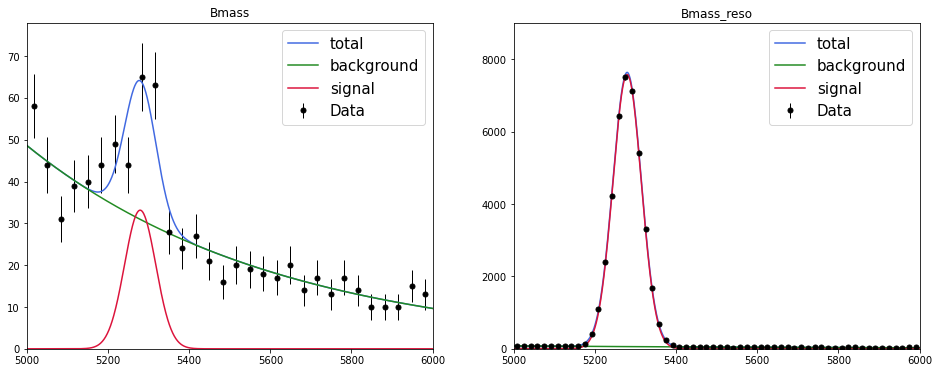

In [18]:
# Sets the values of the parameters to the result of the simultaneous fit
# in case they were modified.
zfit.param.set_values(nll_simultaneous.get_params(), result_simultaneous)

def plot_fit_projection(model, data, nbins=30, ax=None):
    # The function will be reused.
    if ax is None:
        ax = plt.gca()

    lower, upper = data.data_range.limit1d

    # Creates and histogram of the data and plots it with mplhep.
    counts, bin_edges = np.histogram(data.unstack_x(), bins=nbins)
    mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True, 
                    label="Data", ax=ax, color="black")

    binwidth = np.diff(bin_edges)[0]
    x = tf.linspace(lower, upper, num=1000)  # or np.linspace

    # Line plots of the total pdf and the sub-pdfs.
    y = model.ext_pdf(x) * binwidth
    ax.plot(x, y, label="total", color="royalblue")
    for m, l, c in zip(model.get_models(), ["background", "signal"], ["forestgreen", "crimson"]):
        ym = m.ext_pdf(x) * binwidth
        ax.plot(x, ym, label=l, color=c)

    ax.set_title(data.data_range.obs[0])
    ax.set_xlim(lower, upper)
    ax.legend(fontsize=15)

    return ax

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for mod, dat, ax, nb in zip(nll_simultaneous.model, nll_simultaneous.data, axs, [30, 60]):
    plot_fit_projection(mod, dat, nbins=nb, ax=ax)

## Discovery test



We observed an excess of our signal:

In [19]:
print(result_simultaneous.params[sig_yield])

{'value': 96.10030901659354, 'minuit_hesse': {'error': 16.733265730998557}}


Now we would like to compute the significance of this observation or in other words the probabilty that this observation is the result of the statistical fluctuation. To do so we have to perform an hypothesis test where the null and alternative hypotheses are defined as:

* $H_{0}$, the null or background only hypothesis, i.e. $N_{sig} = 0$;
* $H_{1}$, the alternative hypothesis, i.e $N_{sig} = \hat{N}_{sig}$, where $\hat{N}_{sig}$ is the fitted value of $N_{sig}$ printed above.

In `hepstats` to formulate a hypothesis you have to use the `POI` (Parameter Of Interest) class.

In [20]:
from hepstats.hypotests.parameters import POI

# the null hypothesis
sig_yield_poi = POI(sig_yield, 0)

What the `POI` class does is to take as input a `zfit.Parameter` instance and a value corresponding to a given hypothesis. You can notice that we didn't define here the alternative hypothesis as in the discovery test the value of POI for alternate is set to the best fit value.

The test statistic used is the profile likelihood ratio and defined as:

\begin{equation}
q_{0} = \left\{
    \begin{array}{ll}
        -2 \ln \frac{\mathcal{L}(N_{sig}=0, \; \hat{\hat{\theta}})}{\mathcal{L}(N_{sig}=\hat{N}_{sig}, \; \hat{\theta})} & \mbox{if } \; \hat{N}_{sig} \geq 0 \\
        0 & \mbox{if } \; \hat{N}_{sig} < 0
    \end{array}
\right.
\end{equation}

where $\hat{\theta}$ are the best fitted values of the nuisances parameters (i.e. background yield, exponential slope...), while $\hat{\hat{\theta}}$ are the fitted values of the nuisances when ${N}_{sig} = 0$.

From the test statistic distribution a p-value can computed as 

\begin{equation}
p_{0} = \int_{q_{0}^{obs}}^{\infty} f(q_{0} |H_{0}) dq_{0}
\end{equation}

where $q_{0}^{obs}$ is the value of the test statistic evaluated on observed data.

The construction of the test statistic and the computation of the p-value is done in a `Calculator` object in `hepstats`. In this example we will use in this example the `AsymptoticCalculator` calculator which assumes that $q_{0}$ follows a $\chi^2(ndof=1)$ which simplifies the p-value computation to

\begin{equation}
p_{0} = 1 - \Phi\bigg({\sqrt{q_{0}^{obs}}}\bigg).
\end{equation}

The calculator objects takes as input the likelihood function and a minimizer to profile the likelihood.

In [21]:
from hepstats.hypotests.calculators import AsymptoticCalculator

# construction of the calculator instance
calculator = AsymptoticCalculator(input=nll_simultaneous, minimizer=minimizer)
calculator.bestfit = result_simultaneous

# equivalent to above
calculator = AsymptoticCalculator(input=result_simultaneous, minimizer=minimizer)

There is another calculator in `hepstats` called `FrequentistCalculator` which constructs the test statistic distribution $f(q_{0} |H_{0})$ with pseudo-experiments (toys), but it takes more time.

The `Discovery` class is a high-level class that takes as input a calculator and a `POI` instance representing the null hypothesis, it basically asks the calculator to compute the p-value and also computes the signifance as 

\begin{equation}
Z = \Phi^{-1}(1 - p_0).
\end{equation}

In [22]:
from hepstats.hypotests import Discovery

discovery = Discovery(calculator=calculator, poinull=sig_yield_poi)
discovery.result()


p_value for the Null hypothesis = 1.619449019329977e-11
Significance (in units of sigma) = 6.635278774759537


(1.619449019329977e-11, 6.635278774759537)

So we get a significance of about $7\sigma$ which is well above the $5 \sigma$ threshold for discoveries 😃.

## Upper limit calculation

Let's try to compute the discovery significance with a lower number of generated signal events.

In [ ]:
# Sets the values of the parameters to the result of the simultaneous fit
zfit.param.set_values(nll_simultaneous.get_params(), result_simultaneous)
sigma_scaling.floating=False

# Creates a sampler that will draw events from the model
sampler = model.create_sampler()

# Creates new simultaneous loss
nll_simultaneous_low_sig = zfit.loss.ExtendedUnbinnedNLL(model, sampler) + nll_reso

In [ ]:
# Samples with sig_yield = 10. Since the model is extended the number of
# signal generated is drawn from a poisson distribution with lambda = 10.
sampler.resample({sig_yield: 10})

In [ ]:
calculator_low_sig = AsymptoticCalculator(input=nll_simultaneous_low_sig, minimizer=minimizer)

discovery_low_sig = Discovery(calculator=calculator_low_sig, poinull=sig_yield_poi)
discovery_low_sig.result()
print(f"\n {calculator_low_sig.bestfit.params} \n")

We might consider computing an upper limit on the signal yield instead. The test statistic for an upper limit calculation is

\begin{equation}
q_{N_{sig}} = \left\{
    \begin{array}{ll}
        -2 \ln \frac{\mathcal{L}(N_{sig}, \; \hat{\hat{\theta}})}{\mathcal{L}(N_{sig}=\hat{N}_{sig}, \; \hat{\theta})} & \mbox{if } \; \hat{N}_{sig} \leq N_{sig} \\
        0 & \mbox{if } \; \hat{N}_{sig} > N_{sig}.
    \end{array}
\right.
\end{equation}

and the p-value is

\begin{equation}
p_{N_{sig}} = \int_{q_{N_{sig}}^{obs}}^{\infty} f(q_{N_{sig}} |N_{sig}) dq_{N_{sig}}.
\end{equation}

The upper limit on $N_{sig}$, $N_{sig, \uparrow}$ is found for $p_{N_{sig, \uparrow}} = 1 - \alpha$, $\alpha$ being the confidence level (typically $95 \%$). The upper limit is found by interpolation of the p-values as a function of $N_{sig}$, which is done the `UpperLimit` class. We have to give the range of values of $N_{sig}$ to scan using the `POIarray` class which as the `POI` class takes as input the parameter but takes several values to evaluate the parameter instead of one.

In [ ]:
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.parameters import POIarray

# Background only hypothesis.
bkg_only = POI(sig_yield, 0)
# Range of Nsig values to scan.
sig_yield_scan = POIarray(sig_yield, np.linspace(0, 70, 10))

ul = UpperLimit(calculator=calculator_low_sig, poinull=sig_yield_scan, poialt=bkg_only)
ul.upperlimit(alpha=0.05);

In [ ]:
from utils import plotlimit

plotlimit(ul, CLs=False)



## Splot

This is now an demonstration of the **sPlot** algorithm, described in [Pivk:2004ty](https://arxiv.org/pdf/physics/0402083.pdf).

If a data sample is populated by different sources of events, like signal and background, **sPlot** is able to unfold the contributions of the different sources for a given variable.

Let's construct a dataset with two variables, the invariant mass and lifetime, for the resonant signal defined above and the combinatorial background.

In [ ]:
# Signal distributions.
nsig_sw = 20000
np_sig_m_sw = signal_reso.sample(nsig_sw).numpy().reshape(-1,)
np_sig_t_sw = np.random.exponential(size=nsig_sw, scale=1)

# Background distributions.
nbkg_sw = 150000
np_bkg_m_sw = comb_bkg_reso_pdf.sample(nbkg_sw).numpy().reshape(-1,)
np_bkg_t_sw = np.random.normal(size=nbkg_sw, loc=2.0, scale=2.5)

# Lifetime cut.
t_cut = np_bkg_t_sw > 0
np_bkg_t_sw = np_bkg_t_sw[t_cut]
np_bkg_m_sw = np_bkg_m_sw[t_cut]

# Mass distribution
np_m_sw = np.concatenate([np_sig_m_sw, np_bkg_m_sw])

# Lifetime distribution
np_t_sw = np.concatenate([np_sig_t_sw, np_bkg_t_sw])

# Plots the mass and lifetime distribution.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist([np_bkg_m_sw, np_sig_m_sw], bins=50, stacked=True, label=("background", "signal"), alpha=.7)
axs[0].set_xlabel("m")
axs[0].legend(fontsize=15)
axs[1].hist([np_bkg_t_sw, np_sig_t_sw], bins=50, stacked=True, label=("background", "signal"), alpha=.7)
axs[1].set_xlabel("t")
axs[1].legend(fontsize=15);

In this particular example we want to unfold the signal lifetime distribution. To do so **sPlot** needs a discriminant variable to determine the yields of the various sources using an <ins>extended</ins> maximum likelihood fit.

In [ ]:
# Builds the loss.
data_sw = zfit.Data.from_numpy(obs=obs_reso, array=np_m_sw)
nll_sw = zfit.loss.ExtendedUnbinnedNLL(model_reso, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
sigma_scaling.floating=False

# Minimizes the loss.
result_sw = minimizer.minimize(nll_sw)
print(result_sw.params)

In [ ]:
# Visualization of the result.
zfit.param.set_values(nll_sw.get_params(), result_sw)
plot_fit_projection(model_reso, data_sw, nbins=100)

**sPlot** will use the fitted yield for each sources to derive the so-called **sWeights** for each data point:

\begin{equation}
W_{n}(x) = \frac{\sum_{j=1}^{N_S} V_{nj} f_j(x)}{\sum_{k=1}^{N_S} N_{k}f_k(x)}
\end{equation}

with 

\begin{equation}
V_{nj}^{-1} = \sum_{e=1}^{N} \frac{f_n(x_e) f_j(x_e)}{(\sum_{k=1}^{N_S} N_{k}f_k(x))^2}
\end{equation}


where ${N_S}$ is the number of sources in the data sample, here 2. The index $n$ represents the source, for instance $0$ is the signal and $1$ is the background, then $f_0$ and $N_0$ are the pdf and yield for the signal.

In `hepstats` the **sWeights** are computed with the `compute_sweights` function which takes as arguments the <ins>fitted</ins> extended model and the discrimant data (on which the fit was performed).

In [ ]:
from hepstats.splot import compute_sweights

weights = compute_sweights(model_reso, data_sw)

print(weights)

In [ ]:
print("Sum of signal sWeights: ", np.sum(weights[reso_sig_yield]))
print("Sum of background sWeights: ", np.sum(weights[reso_bkg_yield]))

Now we can apply the signal **sWeights** on the lifetime distribution and retrieve its signal components.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
nbins = 40

sorter = np_m_sw.argsort()

axs[0].plot(np_m_sw[sorter], weights[reso_sig_yield][sorter], label="$w_\\mathrm{sig}$")
axs[0].plot(np_m_sw[sorter], weights[reso_bkg_yield][sorter], label="$w_\\mathrm{bkg}$")
axs[0].plot(np_m_sw[sorter], weights[reso_sig_yield][sorter] + weights[reso_bkg_yield][sorter],
            "-k", label="$w_\\mathrm{sig} + w_\\mathrm{bkg}$")
axs[0].axhline(0, color="0.5")
axs[0].legend(fontsize=15)
axs[0].set_xlim(5000, 5600)

axs[1].hist(np_t_sw, bins=nbins, range=(0, 6), weights=weights[reso_sig_yield], label="weighted histogram", alpha=.5)
axs[1].hist(np_sig_t_sw, bins=nbins, range=(0, 6), histtype="step", label="true histogram", lw=1.5)
axs[1].set_xlabel("t")
axs[1].legend(fontsize=15);

Be careful the **sPlot** technique works only on variables that are uncorrelated with the discriminant variable.

In [ ]:
print(f"Correlation between m and t: {np.corrcoef(np_m_sw, np_t_sw)[0, 1]}")

Let's apply to signal **sWeights** on the mass distribution to see how bad the results of **sPlot** is when applied on a variable that is correlated with the discrimant variable.

In [ ]:
plt.hist(np_m_sw, bins=100, range=(5000, 6000), weights=weights[reso_sig_yield]);